<h1><center>Implémentation du GARCH sur une action donnée et quantification par rapport à certaines métriques </center></h1>
<h2><center>LSM Invest Club - Team Quant </center></h2>
<h3><center>Jonathan - Adrien </center></h3>

In [2]:
import pandas as pd
import numpy as np
import yfinance as yf
from yahooquery import Ticker
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from arch import arch_model
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import warnings
import scipy.stats as stats


Paramètres du programme

In [3]:
NomEntreprise = " TotalEnergies "
TickerAction = "TTE"

[*********************100%%**********************]  1 of 1 completed


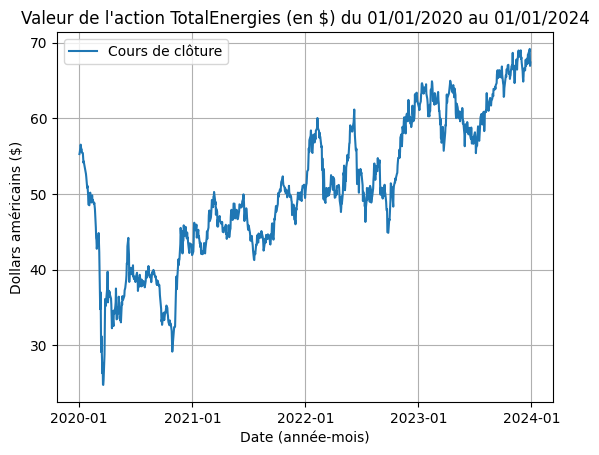

In [4]:
# Récupération des données
data = yf.download(TickerAction, start='2020-01-01', end='2024-01-01')
#data_speed = yf.download(TickerAction, start='2023-06-06', end='2024-01-01', interval='1d')
#data  =  data_speed
data['Log Return'] = np.log(data['Adj Close'] / data['Adj Close'].shift(1))

# Illustration du cours de NVIDIA
plt.locator_params(axis='x', nbins=4)
plt.plot(data.index, data["Close"], label="Cours de clôture")
plt.gca().xaxis.set_major_locator(mdates.YearLocator())  # Un tick par année
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))

plt.xlabel("Date (année-mois)")
plt.ylabel("Dollars américains ($)")
plt.title("Valeur de l'action" + NomEntreprise + "(en $) du 01/01/2020 au 01/01/2024")
plt.grid(True)
plt.legend()
plt.show()

Moyenne des log returns : 0.000464
Écart-type des log returns : 0.023796
VaR à 1% : 0.064623
ES à 1% : 0.108357
VaR à 5% : 0.031203
ES à 5% : 0.055567


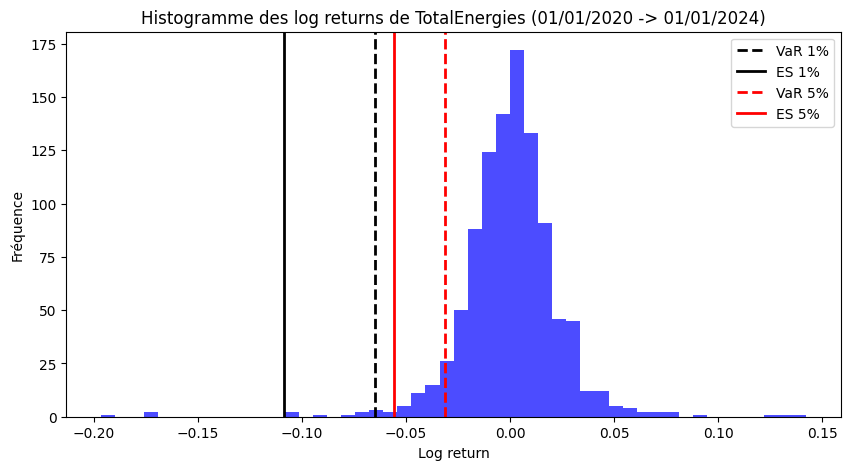

In [5]:
# Analyse des log returns
log_returns = data['Log Return'].dropna()
mean_return = log_returns.mean()
std_return = log_returns.std()

# Calcul de la VaR à 1%
confidence_level = 0.99
var_1 = log_returns.quantile(1 - confidence_level)

log_returns_pd = pd.Series(log_returns)

# Calcul de l'ES (Expected Shortfall) à 1%
ES_1 = np.mean(log_returns_pd[log_returns_pd <= var_1])

# Calcul de la VaR à 5%
confidence_level = 0.95
var_5 = log_returns.quantile(1 - confidence_level)

# Calcul de l'ES (Expected Shortfall) à 5%
ES_5 = np.mean(log_returns_pd[log_returns_pd <= var_5])

# Affichage des résultats
print(f"Moyenne des log returns : {mean_return:.6f}")
print(f"Écart-type des log returns : {std_return:.6f}")
print(f"VaR à 1% : {-var_1:.6f}")
print(f"ES à 1% : {-ES_1:.6f}")
print(f"VaR à 5% : {-var_5:.6f}")
print(f"ES à 5% : {-ES_5:.6f}")

# Visualisation
plt.figure(figsize=(10, 5))
plt.hist(log_returns, bins=50, alpha=0.7, color='blue')
plt.axvline(var_1, color='black', linestyle='dashed', linewidth=2, label = "VaR 1%")
plt.axvline(ES_1, color='black', linewidth=2, label = "ES 1%")
plt.axvline(var_5, color='red', linestyle='dashed', linewidth=2, label = "VaR 5%")
plt.axvline(ES_5, color='red', linewidth=2, label = "ES 5%")
plt.title('Histogramme des log returns de' + NomEntreprise +  '(01/01/2020 -> 01/01/2024)')
plt.xlabel('Log return')
plt.ylabel('Fréquence')
plt.legend()
plt.show()


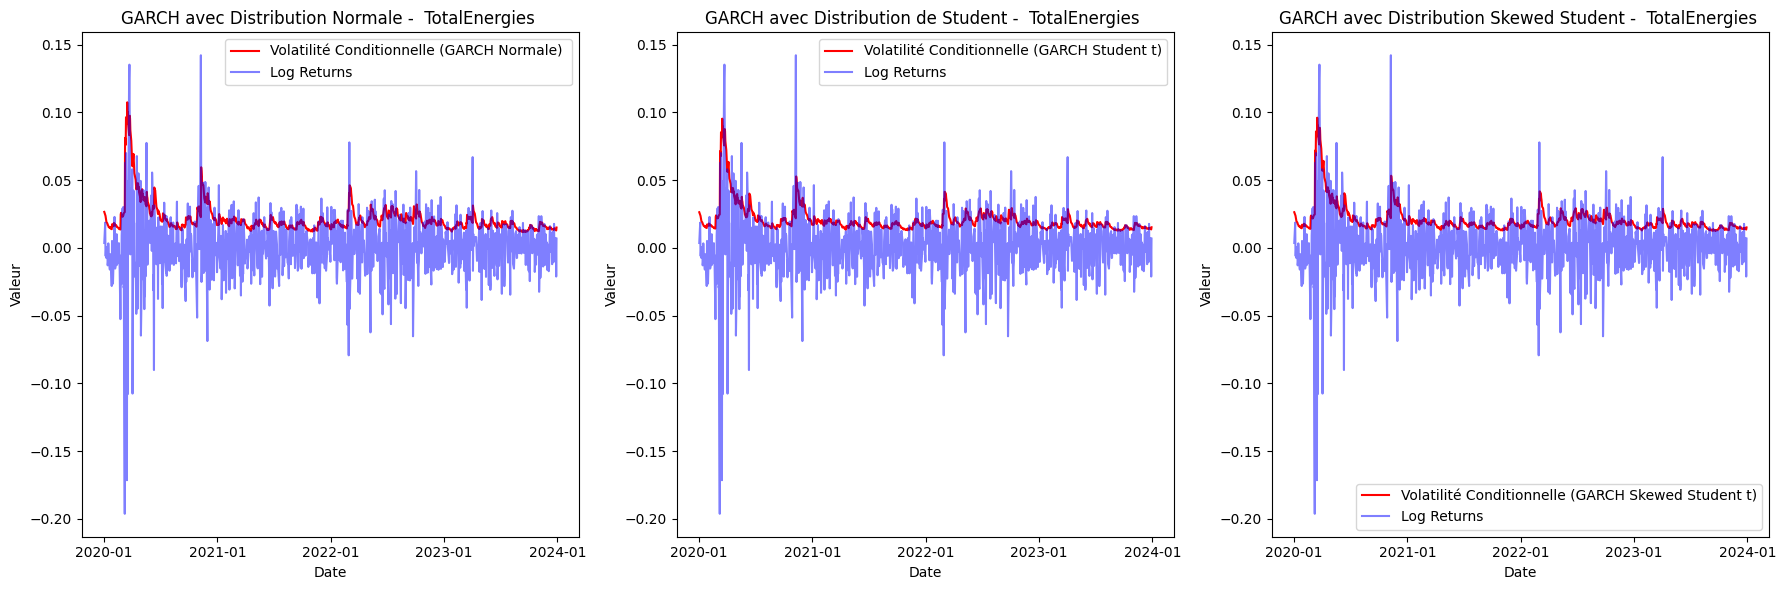

In [6]:
models = {
    'Normal': arch_model(log_returns, vol='Garch', p=1, q=1, dist='normal', rescale=True),
    'Student t': arch_model(log_returns, vol='Garch', p=1, q=1, dist='t', rescale=True),
    'Skewed Student t': arch_model(log_returns, vol='Garch', p=1, q=1, dist='skewt', rescale=True)
}

PredVol = {}
for name, model in models.items():
    garch_fit = model.fit(disp="off")
    PredVol[name] = garch_fit.conditional_volatility

plt.figure(figsize=(18, 6))

# 1. Graphique pour GARCH Normale
plt.subplot(1, 3, 1)
plt.plot(data.index[1:], PredVol['Normal']/100, label='Volatilité Conditionnelle (GARCH Normale) ', color='red')
plt.plot(data.index[1:], log_returns, label='Log Returns', alpha=0.5, color='blue')
plt.title(f'GARCH avec Distribution Normale - {NomEntreprise}')
plt.gca().xaxis.set_major_locator(mdates.YearLocator())  # Un tick par année
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
plt.xlabel('Date')
plt.ylabel('Valeur')
plt.legend()

# 2. Graphique pour GARCH Student t
plt.subplot(1, 3, 2)
plt.plot(data.index[1:], PredVol['Student t']/100, label='Volatilité Conditionnelle (GARCH Student t)', color='red')
plt.plot(data.index[1:], log_returns, label='Log Returns', alpha=0.5, color='blue')
plt.title(f'GARCH avec Distribution de Student - {NomEntreprise}')
plt.gca().xaxis.set_major_locator(mdates.YearLocator())
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
plt.xlabel('Date')
plt.ylabel('Valeur')
plt.legend()

# 3. Graphique pour GARCH Skewed Student t
plt.subplot(1, 3, 3)
plt.plot(data.index[1:], PredVol['Skewed Student t']/100, label='Volatilité Conditionnelle (GARCH Skewed Student t)', color='red')
plt.plot(data.index[1:], log_returns, label='Log Returns', alpha=0.5, color='blue')
plt.title(f'GARCH avec Distribution Skewed Student - {NomEntreprise}')
plt.gca().xaxis.set_major_locator(mdates.YearLocator())
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
plt.xlabel('Date')
plt.ylabel('Valeur')
plt.legend()

plt.tight_layout()
plt.show()


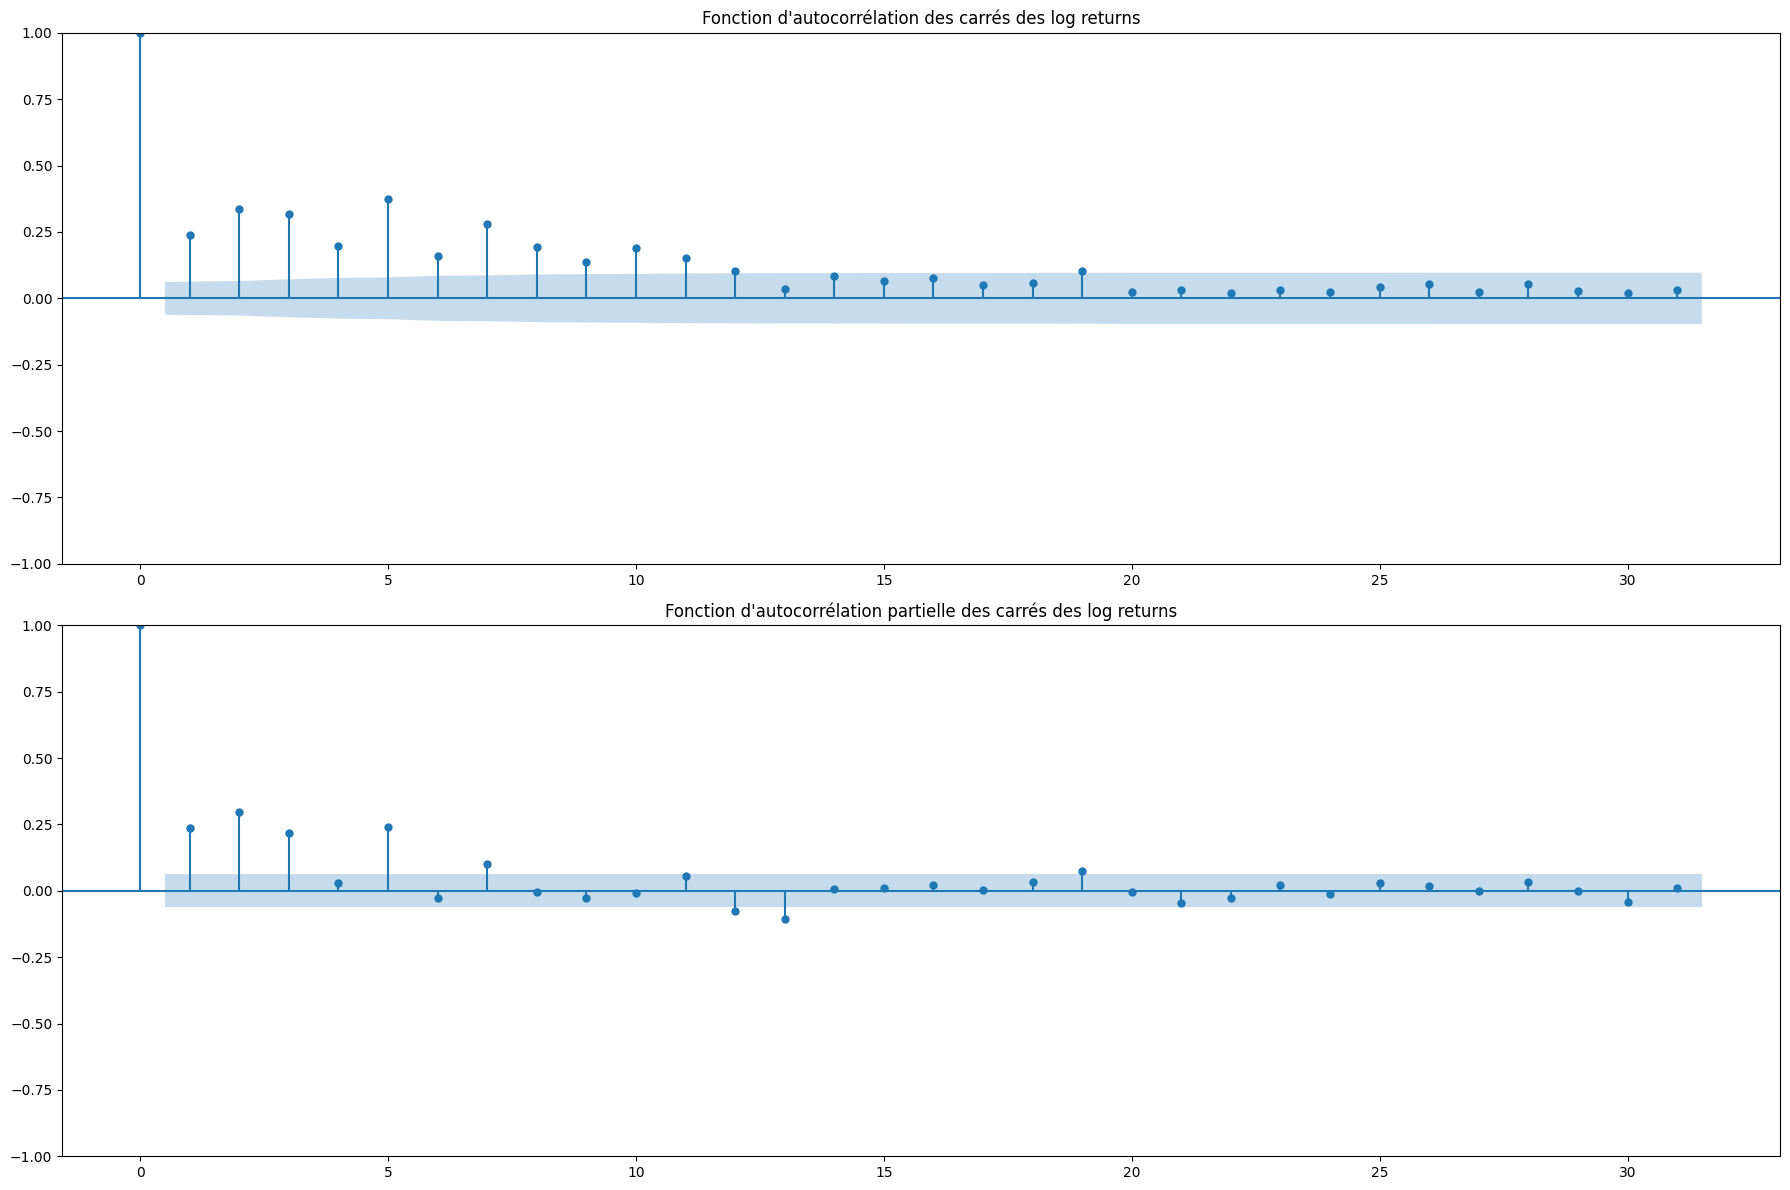

In [7]:
warnings.filterwarnings("ignore")

# Division des données en ensemble d'entraînement et de test
train_size = int(len(log_returns) * 0.8)
train_data = log_returns[:train_size]
test_data = log_returns[train_size:]


# Tracé des graphiques d'autocorrélation 
plt.figure(figsize=(18, 12))

# Autocorrélation et autocorrélation partielle des carrés des log returns
plt.subplot(2, 1, 1)
plot_acf(log_returns**2, ax=plt.gca(), title="Fonction d'autocorrélation des carrés des log returns")
plt.subplot(2, 1, 2)
plot_pacf(log_returns**2, ax=plt.gca(), title="Fonction d'autocorrélation partielle des carrés des log returns")

plt.tight_layout()
plt.show()

## Prédiction en fonction du % en training (0.80,0.85,0.9,0.95) et en fonction du type de distribution (normale, student, skewed student)

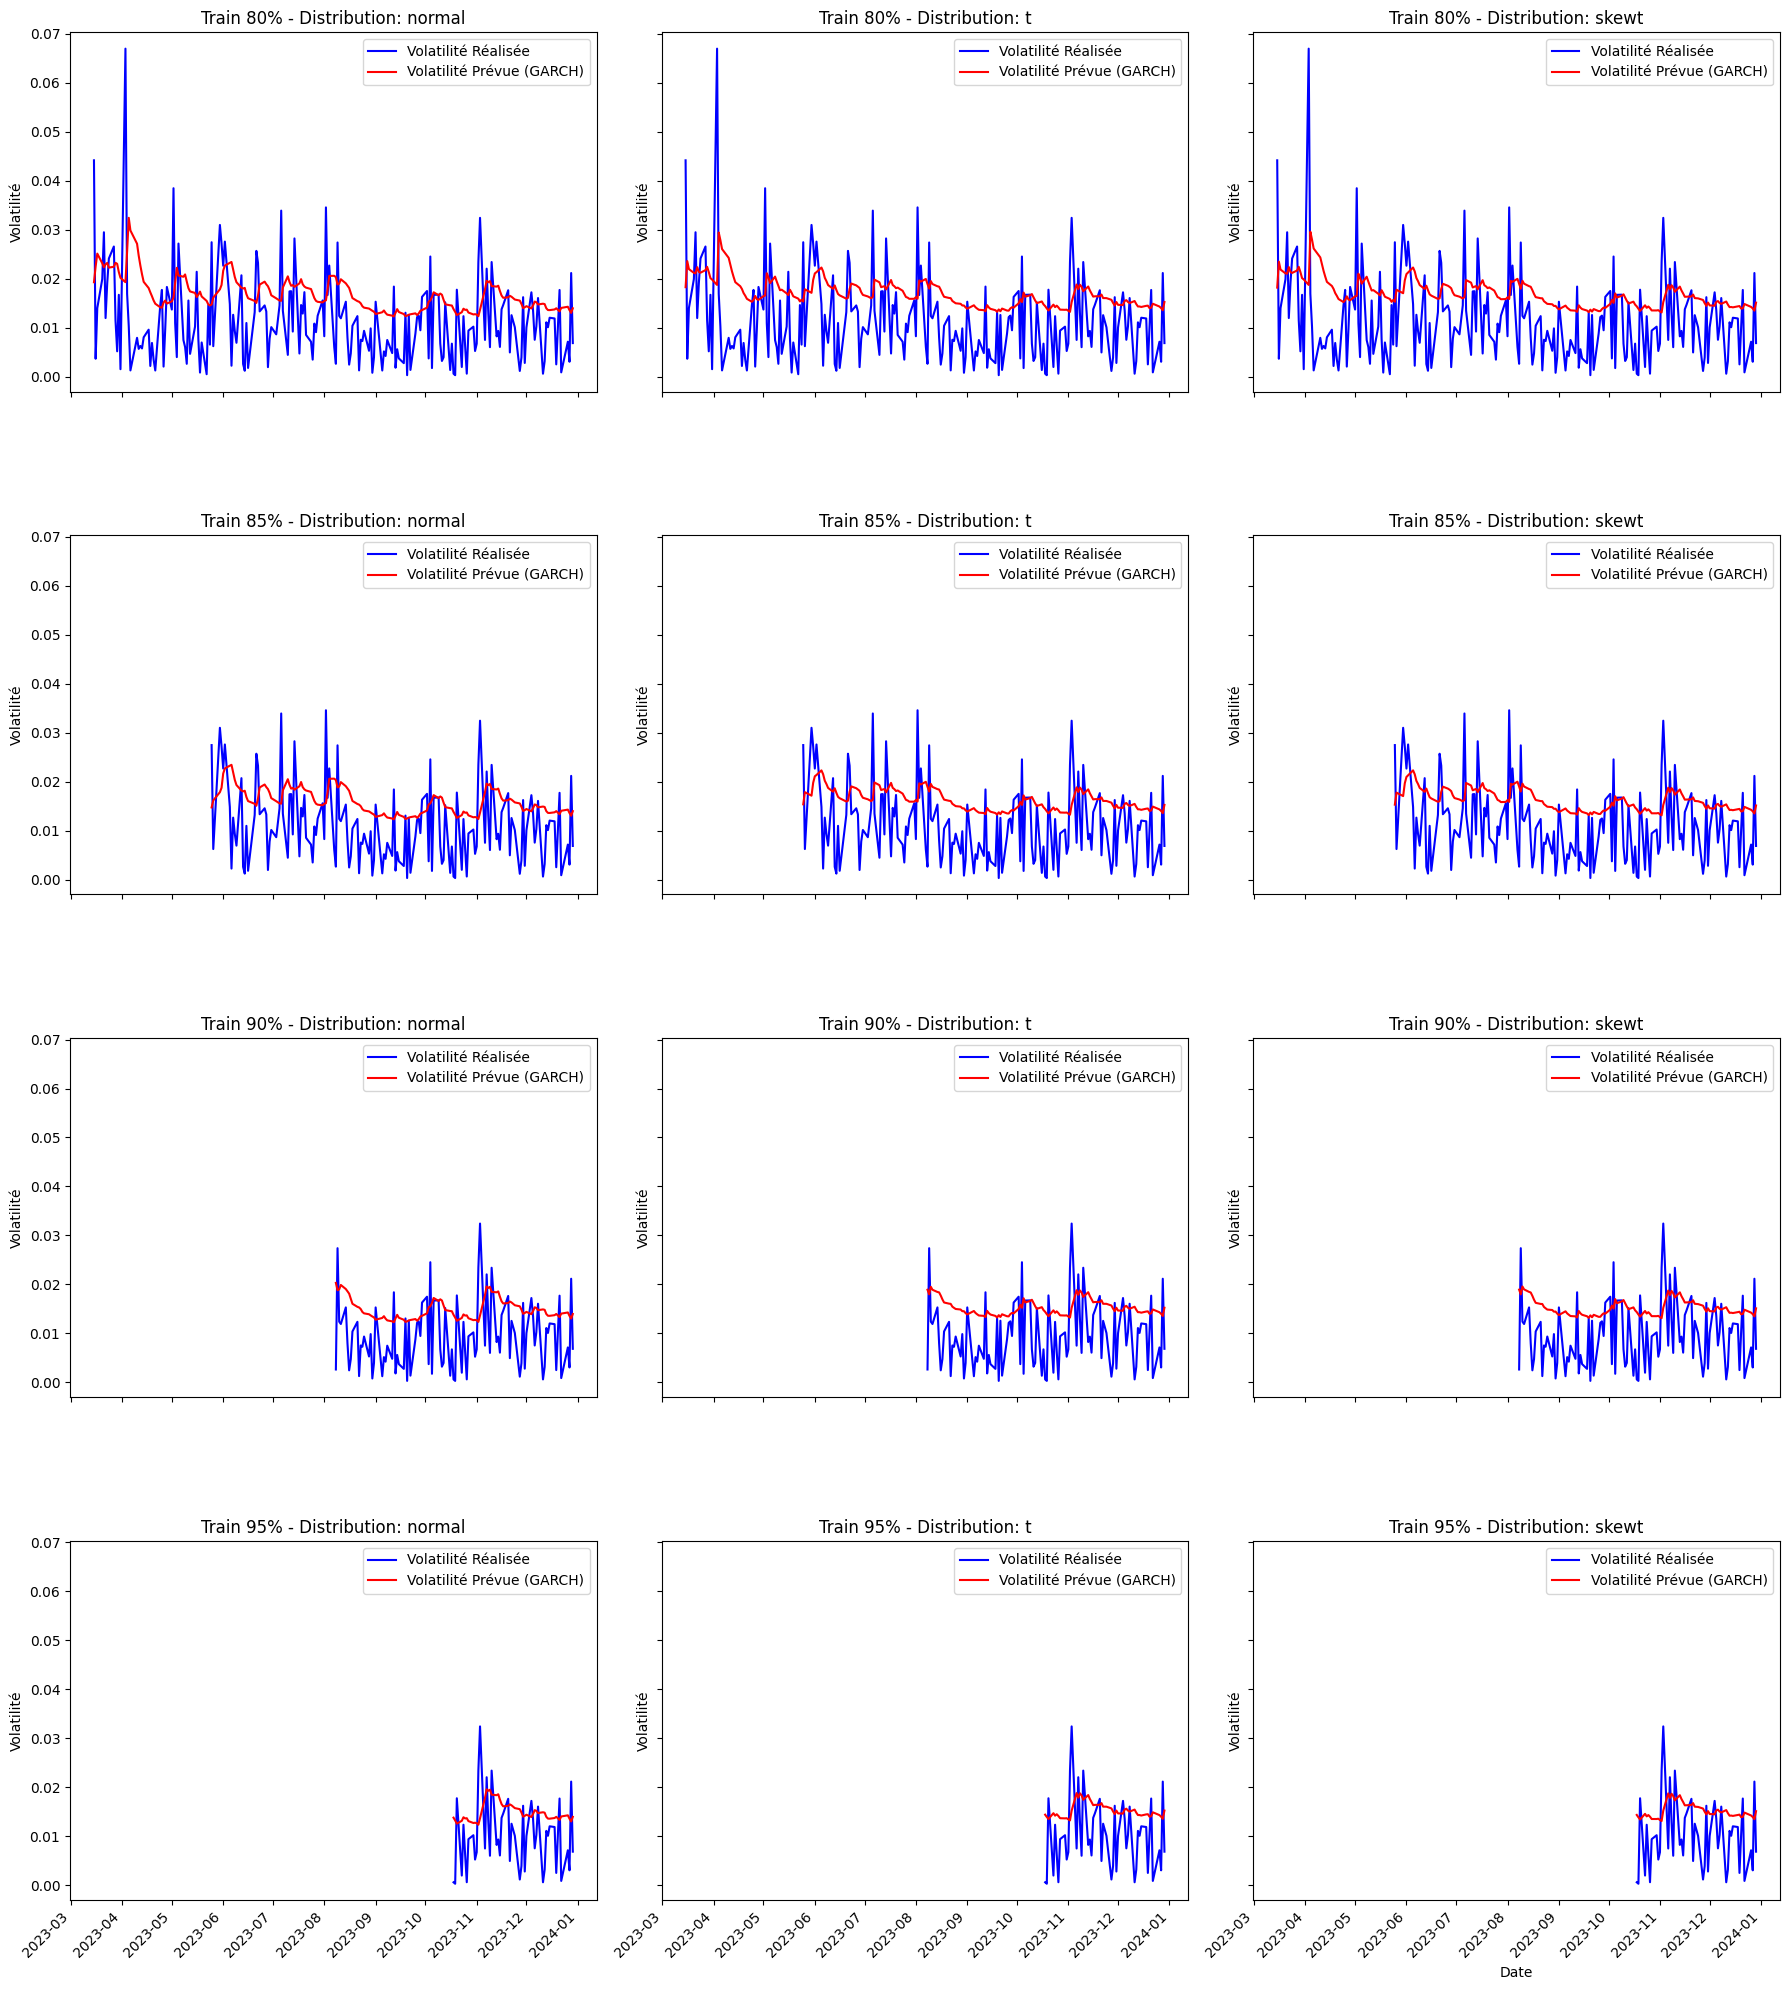

In [8]:
train_sizes = [0.8, 0.85, 0.9, 0.95]
distributions = ['normal', 't', 'skewt']
scaling_factor = 100

fig, axes = plt.subplots(len(train_sizes), 3, figsize=(18, 20), sharex=True, sharey=True)

for size_idx, train_size in enumerate(train_sizes):
    for dist_idx, dist in enumerate(distributions):
        train_split = int(len(log_returns) * train_size)
        train_data = log_returns[:train_split]
        test_data = log_returns[train_split:]

        scaled_train_data = train_data * scaling_factor
        scaled_test_data = test_data * scaling_factor

        best_aic = np.inf
        best_order = None
        best_model = None

        for p in range(1, 3):
            for q in range(1, 3):
                try:
                    model = arch_model(scaled_train_data, vol='Garch', p=p, q=q, dist=dist)
                    model_fit = model.fit(disp='off')
                    aic = model_fit.aic
                    if aic < best_aic:
                        best_aic = aic
                        best_order = (p, q)
                        best_model = model_fit
                except Exception as e:
                    continue

        rolling_predictions = []
        history = list(scaled_train_data)

        for t in range(len(scaled_test_data)):
            model = arch_model(history, vol='Garch', p=best_order[0], q=best_order[1], dist=dist)
            model_fit = model.fit(disp='off')
            pred = model_fit.forecast(horizon=1)
            predicted_volatility = np.sqrt(pred.variance.values[-1, :][0])
            rolling_predictions.append(predicted_volatility)
            history.append(scaled_test_data[t])

        rolling_predictions = np.array(rolling_predictions) / scaling_factor
        realized_volatility = np.abs(test_data)

        # Visualisation dans le bon subplot
        ax = axes[size_idx, dist_idx]
        ax.plot(test_data.index, realized_volatility, label='Volatilité Réalisée', color='blue')
        ax.plot(test_data.index, rolling_predictions, label='Volatilité Prévue (GARCH)', color='red')

        # Configuration du graphique
        ax.set_title(f'Train {int(train_size * 100)}% - Distribution: {dist}')
        ax.set_ylabel('Volatilité')
        ax.legend()
        ax.xaxis.set_major_locator(mdates.MonthLocator())
        ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
        plt.setp(ax.xaxis.get_majorticklabels(), rotation=45, ha='right')

plt.xlabel('Date')
plt.tight_layout()
plt.subplots_adjust(hspace=0.4)
plt.show()

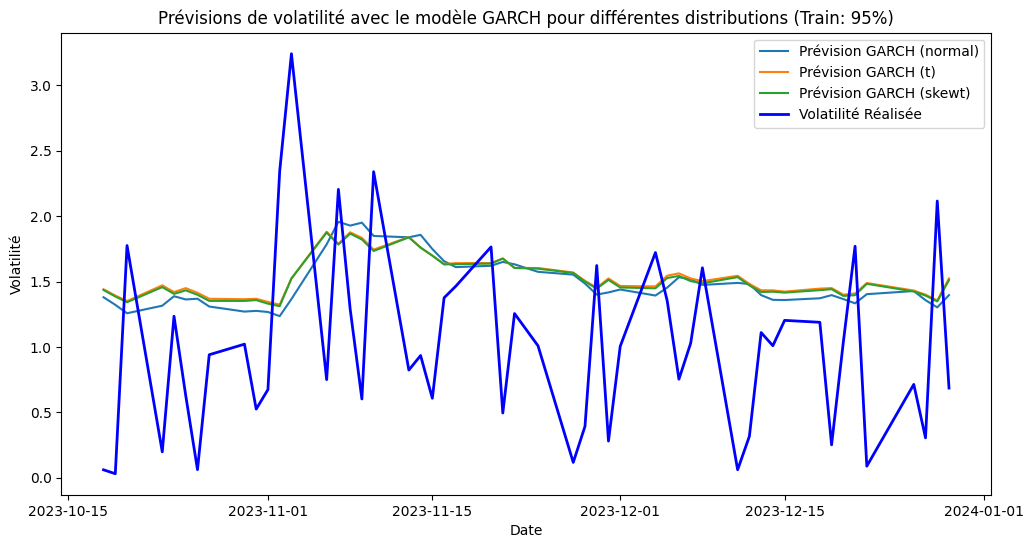

In [9]:
all_rolling_predictions = []
train_size_ratio = 0.95

train_size = int(len(log_returns) * train_size_ratio)
train_data = log_returns[:train_size]
test_data = log_returns[train_size:]

scaling_factor = 100
scaled_train_data = train_data * scaling_factor
scaled_test_data = test_data * scaling_factor

distributions = ['normal', 't', 'skewt']
best_orders = []
for dist in distributions:
    best_aic = np.inf
    best_order = None

    for p in range(1, 3):
        for q in range(1, 3):
            try:
                model = arch_model(scaled_train_data, vol='Garch', p=p, q=q, dist=dist)
                model_fit = model.fit(disp='off')
                aic = model_fit.aic
                if aic < best_aic:
                    best_aic = aic
                    best_order = (p, q)
            except Exception as e:
                continue
    best_orders.append(best_order)
    rolling_predictions = []
    history = list(scaled_train_data)

    for t in range(len(scaled_test_data)):
        model = arch_model(history, vol='Garch', p=best_order[0], q=best_order[1], dist=dist)
        model_fit = model.fit(disp='off')
        pred = model_fit.forecast(horizon=1)
        predicted_volatility = np.sqrt(pred.variance.values[-1, :][0])
        rolling_predictions.append(predicted_volatility)
        history.append(scaled_test_data[t])

    rolling_predictions = np.array(rolling_predictions)
    all_rolling_predictions.append(rolling_predictions)

realized_volatility = np.abs(test_data) * scaling_factor

plt.figure(figsize=(12, 6))

for idx, predictions in enumerate(all_rolling_predictions):
    plt.plot(test_data.index[:len(predictions)], predictions, label=f'Prévision GARCH ({distributions[idx]})')

plt.plot(test_data.index, realized_volatility, label='Volatilité Réalisée', color='blue', linewidth=2)
plt.title('Prévisions de volatilité avec le modèle GARCH pour différentes distributions (Train: 95%)')
plt.xlabel('Date')
plt.ylabel('Volatilité')
plt.legend()
plt.show()


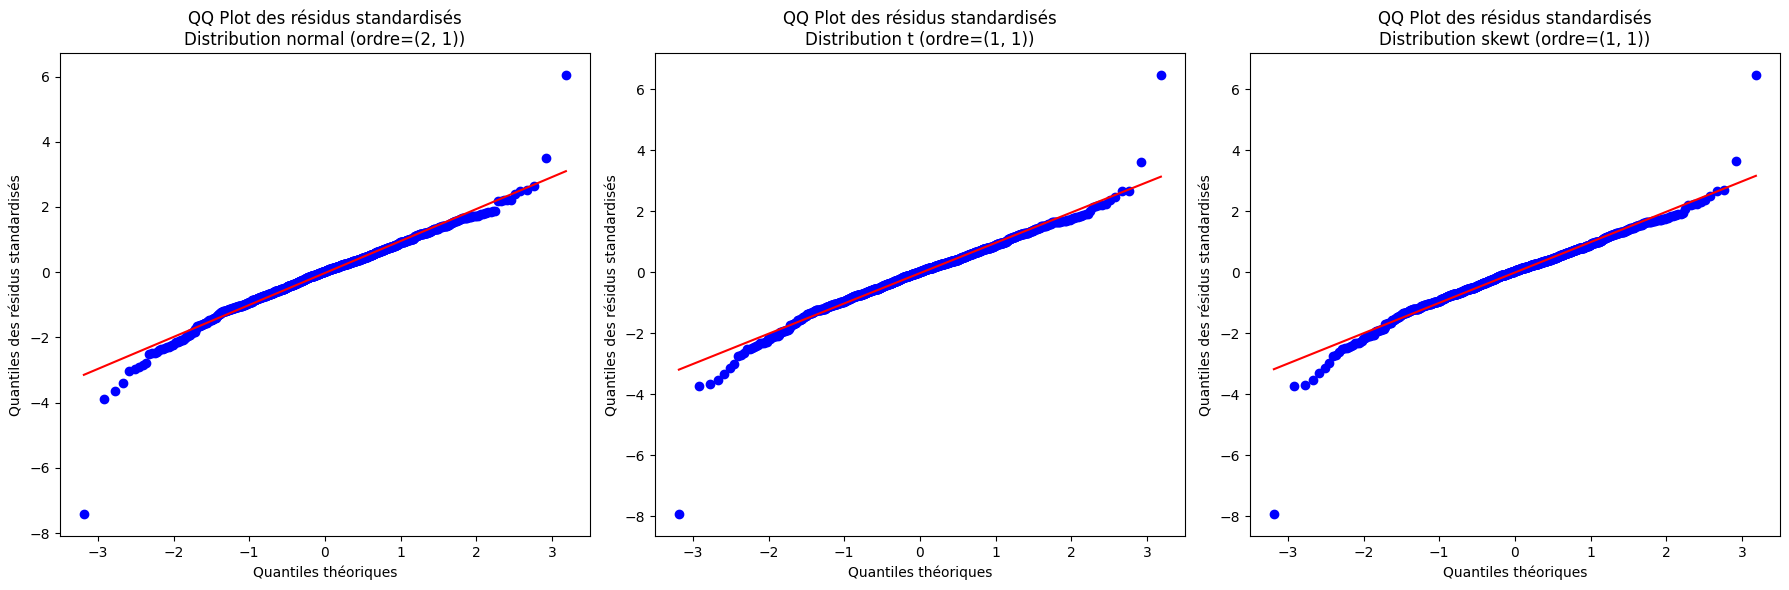

In [10]:
# Créer une figure pour afficher les QQ plots côte à côte
plt.figure(figsize=(18, 6))  # Largeur augmentée pour accueillir les plots côte à côte

# Boucle pour calculer et afficher le QQ plot pour chaque distribution
for idx, dist in enumerate(distributions):
    # Meilleur ordre trouvé pour la distribution actuelle
    best_order = best_orders[idx]

    # Ajustement du modèle avec les meilleurs paramètres sur les données d'entraînement
    model = arch_model(scaled_train_data, vol='Garch', p=best_order[0], q=best_order[1], dist=dist)
    model_fit = model.fit(disp='off')

    # Calcul des résidus standardisés
    standardized_residuals = model_fit.std_resid

    # Création du QQ plot dans une sous-figure
    plt.subplot(1, len(distributions), idx + 1)  # 1 ligne, nombre de colonnes = nombre de distributions
    stats.probplot(standardized_residuals, dist="norm", plot=plt)
    plt.title(f"QQ Plot des résidus standardisés\nDistribution {dist} (ordre={best_order})")
    plt.xlabel("Quantiles théoriques")
    plt.ylabel("Quantiles des résidus standardisés")

# Ajustement de l'affichage et affichage final
plt.tight_layout()
plt.show()


## QQPlot corrects, meilleurs dès qu'on passe sur les distributions T, surtout si on enlève les outliers, mais il persiste un problème sur les points se trouvant à gauche, à inspecter.

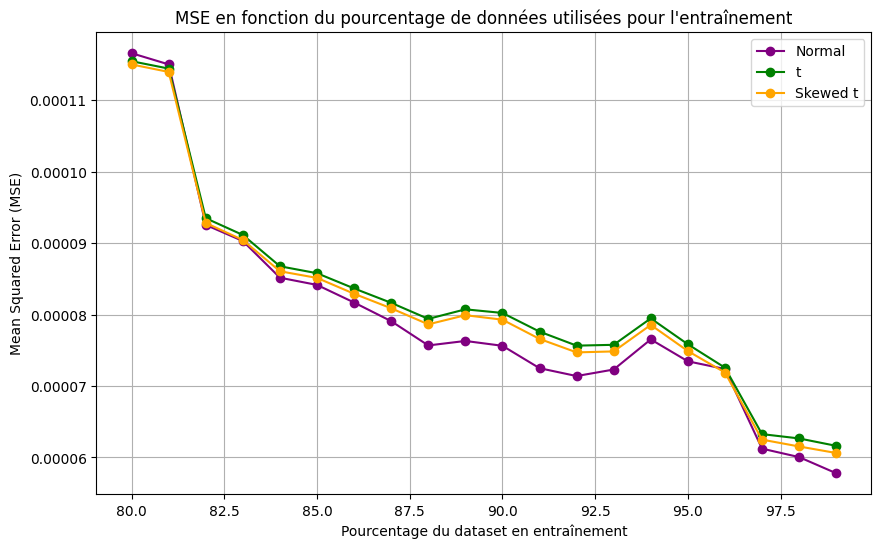

In [11]:
from sklearn.metrics import mean_squared_error
mse_values_normal = []
mse_values_t = []
mse_values_skewt = []
train_sizes = np.linspace(0.80, 0.99, 20)

for train_size_ratio in train_sizes:
    best_aic = np.inf
    p, q = None, None

    train_size = int(len(log_returns) * train_size_ratio)
    train_data = log_returns[:train_size]
    test_data = log_returns[train_size:]

    scaled_train_data = train_data * scaling_factor
    scaled_test_data = test_data * scaling_factor

    for dist in ['normal', 't', 'skewt']:
    
        best_aic = np.inf
        for ptest in range(1, 4):
            for qtest in range(1, 4):
                try:
                    model = arch_model(scaled_train_data, vol='Garch', p=ptest, q=qtest, dist=dist)
                    model_fit = model.fit(disp='off')
                    aic = model_fit.aic
                    if aic < best_aic:
                        p = ptest
                        q = qtest
                except Exception as e:
                    continue

        rolling_predictions = []
        history = list(scaled_train_data)

        for t in range(len(scaled_test_data)):
            model = arch_model(history, vol='Garch', p=p, q=q, dist=dist)
            model_fit = model.fit(disp='off')
            pred = model_fit.forecast(horizon=1)
            predicted_volatility = np.sqrt(pred.variance.values[-1, :][0])
            rolling_predictions.append(predicted_volatility)
            history.append(scaled_test_data[t])

        rolling_predictions = np.array(rolling_predictions) / scaling_factor
        realized_volatility = np.abs(test_data)

        root_mse = mean_squared_error(realized_volatility, rolling_predictions)
        if dist == 'normal':
            mse_values_normal.append(root_mse)
        elif dist == 't':
            mse_values_t.append(root_mse)
        elif dist == 'skewt':
            mse_values_skewt.append(root_mse)

plt.figure(figsize=(10, 6))
plt.plot(train_sizes * 100, mse_values_normal, marker='o', color='purple', label='Normal')
plt.plot(train_sizes * 100, mse_values_t, marker='o', color='green', label='t')
plt.plot(train_sizes * 100, mse_values_skewt, marker='o', color='orange', label='Skewed t')
plt.title("MSE en fonction du pourcentage de données utilisées pour l'entraînement")
plt.xlabel("Pourcentage du dataset en entraînement")
plt.ylabel("Mean Squared Error (MSE)")
plt.grid(True)
plt.legend()
plt.show()

### Autres métriques : 

Précision directionnelle à la hausse ou à la baisse

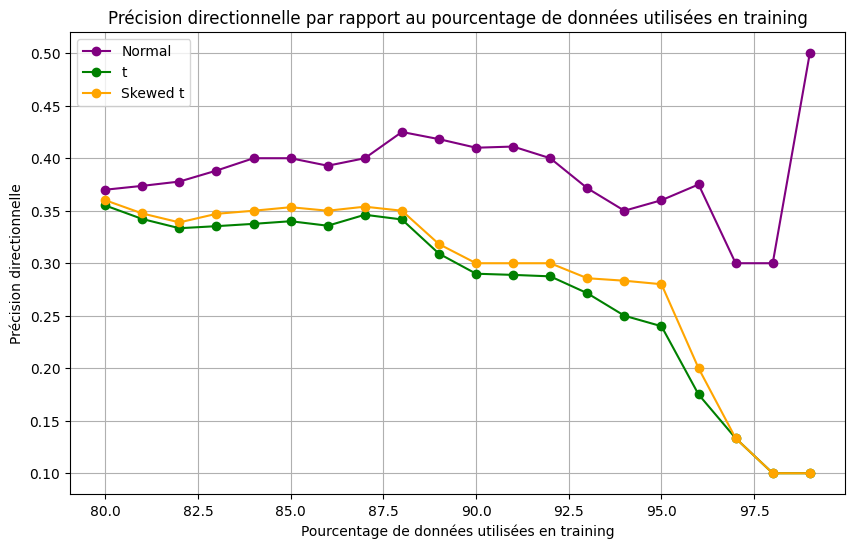

In [12]:
from sklearn.metrics import accuracy_score

accuracy_values_normal = []
accuracy_values_t = []
accuracy_values_skewt = []
train_sizes = np.linspace(0.80, 0.99, 20)

for train_size_ratio in train_sizes:
    best_aic = np.inf
    p, q = None, None

    train_size = int(len(log_returns) * train_size_ratio)
    train_data = log_returns[:train_size]
    test_data = log_returns[train_size:]

    scaled_train_data = train_data * scaling_factor
    scaled_test_data = test_data * scaling_factor

    for dist in ['normal', 't', 'skewt']:
        best_aic = np.inf
        for ptest in range(1, 4):
            for qtest in range(1, 4):
                try:
                    model = arch_model(scaled_train_data, vol='Garch', p=ptest, q=qtest, dist=dist)
                    model_fit = model.fit(disp='off')
                    aic = model_fit.aic
                    if aic < best_aic:
                        p = ptest
                        q = qtest
                except Exception as e:
                    continue

        rolling_predictions = []
        history = list(scaled_train_data)

        for t in range(len(scaled_test_data)):
            model = arch_model(history, vol='Garch', p=p, q=q, dist=dist)
            model_fit = model.fit(disp='off')
            pred = model_fit.forecast(horizon=1)
            predicted_volatility = np.sqrt(pred.variance.values[-1, :][0])
            rolling_predictions.append(predicted_volatility)
            history.append(scaled_test_data[t])

        rolling_predictions = np.array(rolling_predictions) / scaling_factor
        realized_volatility = np.abs(test_data)

        # Calculate direction accuracy
        direction_realized = np.sign(np.diff(realized_volatility))
        direction_predicted = np.sign(np.diff(rolling_predictions))
        direction_accuracy = accuracy_score(direction_realized, direction_predicted)

        if dist == 'normal':
            accuracy_values_normal.append(direction_accuracy)
        elif dist == 't':
            accuracy_values_t.append(direction_accuracy)
        elif dist == 'skewt':
            accuracy_values_skewt.append(direction_accuracy)

plt.figure(figsize=(10, 6))
plt.plot(train_sizes * 100, accuracy_values_normal, marker='o', color='purple', label='Normal')
plt.plot(train_sizes * 100, accuracy_values_t, marker='o', color='green', label='t')
plt.plot(train_sizes * 100, accuracy_values_skewt, marker='o', color='orange', label='Skewed t')
plt.title("Précision directionnelle par rapport au pourcentage de données utilisées en training")
plt.xlabel("Pourcentage de données utilisées en training")
plt.ylabel("Précision directionnelle")
plt.grid(True)
plt.legend()
plt.show()


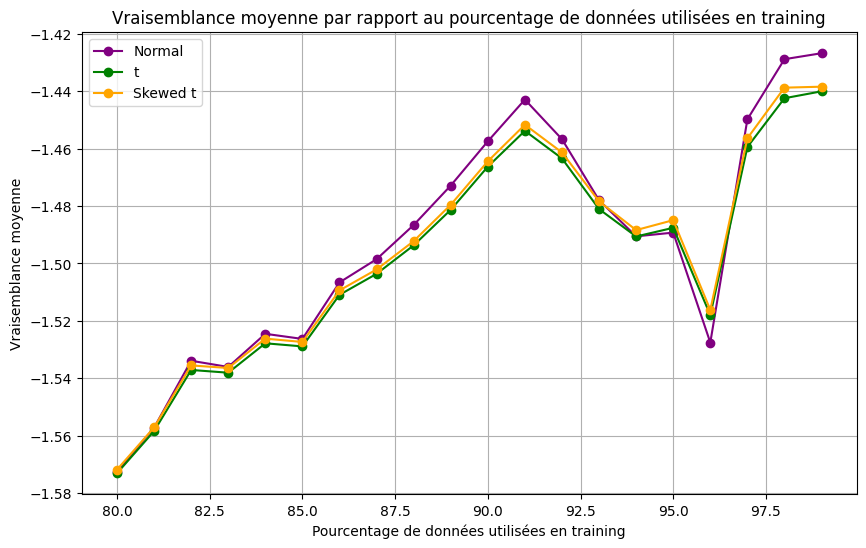

In [14]:
from scipy.stats import t as t_dist
from scipy.stats import norm
likelihood_values_normal = []
likelihood_values_t = []
likelihood_values_skewt = []

train_sizes = np.linspace(0.80, 0.99, 20)

for train_size_ratio in train_sizes:
    best_aic = np.inf
    p, q = None, None

    train_size = int(len(log_returns) * train_size_ratio)
    train_data = log_returns[:train_size]
    test_data = log_returns[train_size:]

    scaled_train_data = train_data * scaling_factor
    scaled_test_data = test_data * scaling_factor

    for dist in ['normal', 't', 'skewt']:
        best_aic = np.inf
        best_model_fit = None
        for ptest in range(1, 4):
            for qtest in range(1, 4):
                try:
                    model = arch_model(scaled_train_data, vol='Garch', p=ptest, q=qtest, dist=dist)
                    model_fit = model.fit(disp='off')
                    aic = model_fit.aic
                    if aic < best_aic:
                        best_aic = aic
                        best_model_fit = model_fit
                        p, q = ptest, qtest
                except Exception as e:
                    continue

        likelihood_sum = 0
        history = list(scaled_train_data)

        for t in range(len(scaled_test_data)):
            model = arch_model(history, vol='Garch', p=p, q=q, dist=dist)
            model_fit = model.fit(disp='off')
            pred = model_fit.forecast(horizon=1)
            predicted_volatility = np.sqrt(pred.variance.values[-1, :][0])
            standardized_residual = (scaled_test_data[t] - model_fit.params['mu']) / predicted_volatility
            
            if dist == 'normal':
                likelihood_sum += norm.logpdf(standardized_residual, loc=0, scale=predicted_volatility)
            elif dist == 't':
                likelihood_sum += t_dist.logpdf(standardized_residual, df=803, scale=predicted_volatility)
            elif dist == 'skewt':
                likelihood_sum += t_dist.logpdf(standardized_residual, df=803, scale=predicted_volatility)

            history.append(scaled_test_data[t])
        
        avg_likelihood = likelihood_sum / len(scaled_test_data)
        
        if dist == 'normal':
            likelihood_values_normal.append(avg_likelihood)
        elif dist == 't':
            likelihood_values_t.append(avg_likelihood)
        elif dist == 'skewt':
            likelihood_values_skewt.append(avg_likelihood)

plt.figure(figsize=(10, 6))
plt.plot(train_sizes * 100, likelihood_values_normal, marker='o', color='purple', label='Normal')
plt.plot(train_sizes * 100, likelihood_values_t, marker='o', color='green', label='t')
plt.plot(train_sizes * 100, likelihood_values_skewt, marker='o', color='orange', label='Skewed t')
plt.title("Vraisemblance moyenne par rapport au pourcentage de données utilisées en training")
plt.xlabel("Pourcentage de données utilisées en training")
plt.ylabel("Vraisemblance moyenne")
plt.grid(True)
plt.legend()
plt.show()


La vraisemblance moyenne est une mesure qui évalue dans quelle mesure le modèle correspond aux données observées. Plus la vraisemblance est élevée, plus le modèle est adapté pour expliquer les données.

- Pour chaque observation dans les données de test (`scaled_test_data`), le modèle GARCH prédit la volatilité conditionnelle du jour suivant.
- La différence entre la valeur observée et la moyenne (`mu` du modèle) est divisée par la volatilité prédite pour obtenir le **résidu standardisé**.
- La vraisemblance du résidu standardisé est calculée à l’aide de la fonction de densité de probabilité (log-pdf) de la distribution choisie (normal, t de Student ou t asymétrique).
- Ce score de vraisemblance est ajouté au total de vraisemblance (`likelihood_sum`), afin de cumuler la vraisemblance de chaque prévision dans les données de test.

Une fois toutes les vraisemblances calculées, la vraisemblance moyenne est obtenue en divisant `likelihood_sum` par le nombre d’observations dans le jeu de test.
QQ -plot 


# Pourcentage d'errreur  à chaque instant de pas

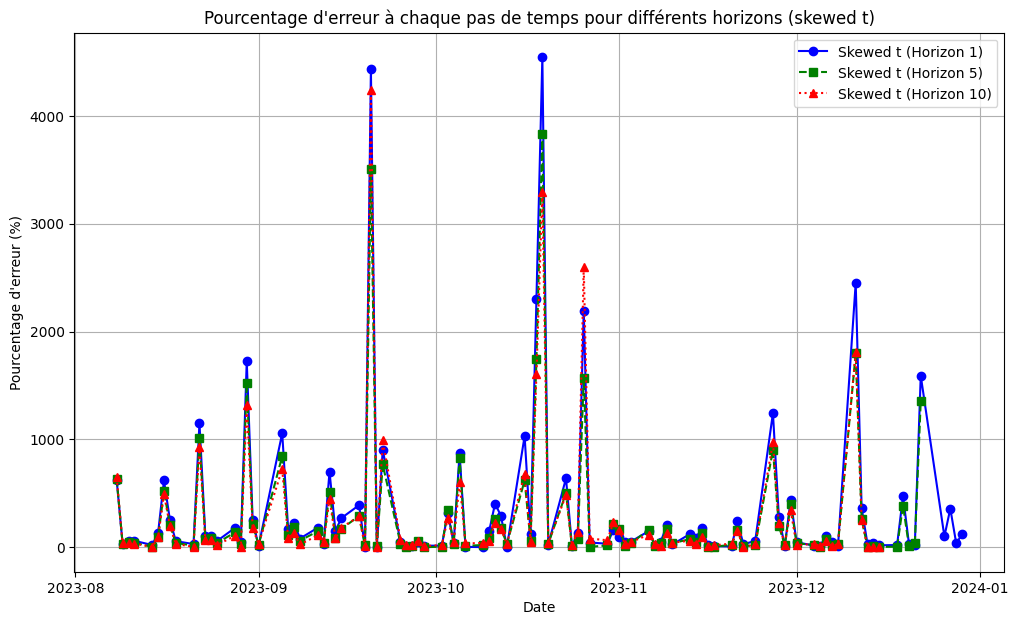

In [15]:
horizons = [1, 5, 10]  # Définit les horizons de prévision en jours
percentage_errors_horizons_skewt = {h: [] for h in horizons}

# Taille d'entraînement
train_size_ratio = 0.90
train_size = int(len(log_returns) * train_size_ratio)
train_data = log_returns[:train_size]
test_data = log_returns[train_size:]
scaled_train_data = train_data * scaling_factor
scaled_test_data = test_data * scaling_factor

# Paramètres optimaux pour la distribution 'skewt'
best_aic = np.inf
best_order = (1, 1)

# Recherche des meilleurs paramètres (p, q)
for p in range(1, 4):
    for q in range(1, 4):
        try:
            model = arch_model(scaled_train_data, vol='Garch', p=p, q=q, dist='skewt')
            model_fit = model.fit(disp='off')
            if model_fit.aic < best_aic:
                best_aic = model_fit.aic
                best_order = (p, q)
        except Exception as e:
            continue

# Calcul des erreurs de pourcentage pour chaque horizon
for h in horizons:
    rolling_predictions = []
    history = list(scaled_train_data)

    for t in range(len(scaled_test_data) - h + 1):
        model = arch_model(history, vol='Garch', p=best_order[0], q=best_order[1], dist='skewt')
        model_fit = model.fit(disp='off')
        pred = model_fit.forecast(horizon=h)
        predicted_volatility = np.sqrt(pred.variance.values[-1, :]).mean()  # Moyenne de l'horizon
        rolling_predictions.append(predicted_volatility)
        history.extend(scaled_test_data[t:t+h])  # Mise à jour de l'historique avec l'horizon

    # Calcul du pourcentage d'erreur pour l'horizon donné
    rolling_predictions = np.array(rolling_predictions) / scaling_factor
    realized_volatility = np.abs(test_data[:len(rolling_predictions)])
    percentage_errors = np.abs((realized_volatility - rolling_predictions) / realized_volatility) * 100

    # Stockage des erreurs pour le plot
    percentage_errors_horizons_skewt[h] = percentage_errors

# Tracé des erreurs de pourcentage pour chaque horizon sur un seul graphique avec des styles différents
plt.figure(figsize=(12, 7))
styles = {1: ('-', 'o', 'blue'), 5: ('--', 's', 'green'), 10: (':', '^', 'red')}
for h in horizons:
    line_style, marker, color = styles[h]
    plt.plot(test_data.index[:len(percentage_errors_horizons_skewt[h])], 
             percentage_errors_horizons_skewt[h], linestyle=line_style, marker=marker, color=color,
             label=f'Skewed t (Horizon {h})')

plt.title("Pourcentage d'erreur à chaque pas de temps pour différents horizons (skewed t)")
plt.xlabel("Date")
plt.ylabel("Pourcentage d'erreur (%)")
plt.legend()
plt.grid(True)
plt.show()


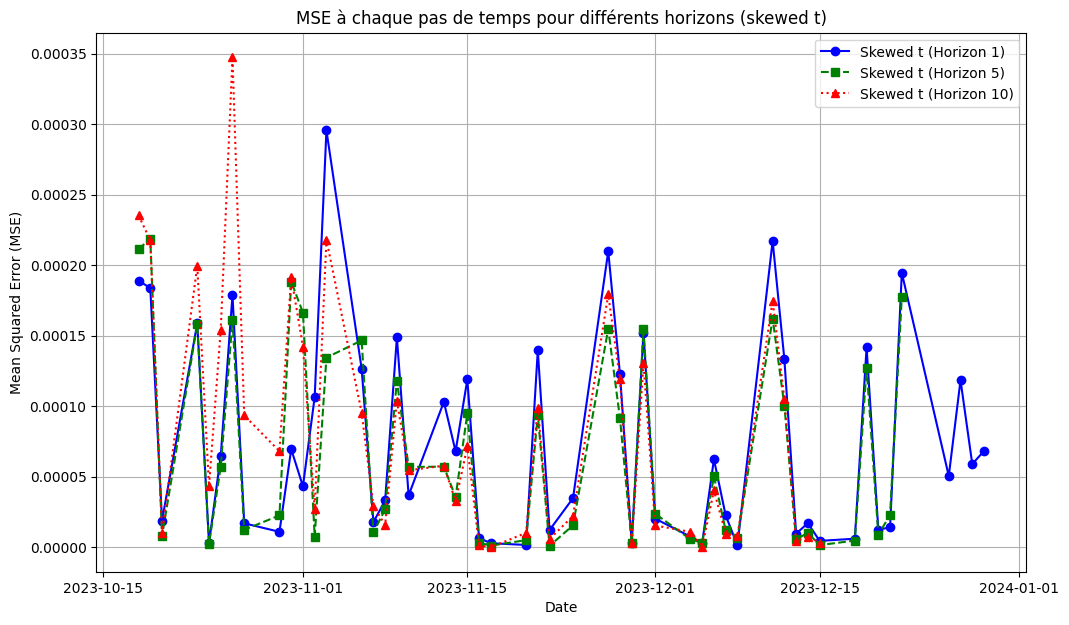

In [16]:
from sklearn.metrics import mean_squared_error

horizons = [1, 5, 10]  # Définit les horizons de prévision en jours
mse_horizons_skewt = {h: [] for h in horizons}

# Taille d'entraînement
train_size_ratio = 0.95
train_size = int(len(log_returns) * train_size_ratio)
train_data = log_returns[:train_size]
test_data = log_returns[train_size:]
scaled_train_data = train_data * scaling_factor
scaled_test_data = test_data * scaling_factor

# Paramètres optimaux pour la distribution 'skewt'
best_aic = np.inf
best_order = (1, 1)

# Recherche des meilleurs paramètres (p, q)
for p in range(1, 4):
    for q in range(1, 4):
        try:
            model = arch_model(scaled_train_data, vol='Garch', p=p, q=q, dist='skewt')
            model_fit = model.fit(disp='off')
            if model_fit.aic < best_aic:
                best_aic = model_fit.aic
                best_order = (p, q)
        except Exception as e:
            continue

# Calcul de la MSE pour chaque horizon
for h in horizons:
    rolling_predictions = []
    history = list(scaled_train_data)

    for t in range(len(scaled_test_data) - h + 1):
        model = arch_model(history, vol='Garch', p=best_order[0], q=best_order[1], dist='skewt')
        model_fit = model.fit(disp='off')
        pred = model_fit.forecast(horizon=h)
        predicted_volatility = np.sqrt(pred.variance.values[-1, :]).mean()  # Moyenne de l'horizon
        rolling_predictions.append(predicted_volatility)
        history.extend(scaled_test_data[t:t+h])  # Mise à jour de l'historique avec l'horizon

    # Conversion des prédictions en array pour chaque horizon
    rolling_predictions = np.array(rolling_predictions) / scaling_factor
    realized_volatility = np.abs(test_data[:len(rolling_predictions)])
    
    # Calcul de la MSE à chaque pas de temps pour cet horizon
    mse_values = (realized_volatility - rolling_predictions) ** 2
    mse_horizons_skewt[h] = mse_values  # Stockage de la MSE pour chaque pas de temps

# Tracé de la MSE pour chaque horizon sur un seul graphique avec des styles différents
plt.figure(figsize=(12, 7))
styles = {1: ('-', 'o', 'blue'), 5: ('--', 's', 'green'), 10: (':', '^', 'red')}
for h in horizons:
    line_style, marker, color = styles[h]
    plt.plot(test_data.index[:len(mse_horizons_skewt[h])], 
             mse_horizons_skewt[h], linestyle=line_style, marker=marker, color=color,
             label=f'Skewed t (Horizon {h})')

plt.title("MSE à chaque pas de temps pour différents horizons (skewed t)")
plt.xlabel("Date")
plt.ylabel("Mean Squared Error (MSE)")
plt.legend()
plt.grid(True)
plt.show()


## GARCH exponentiel

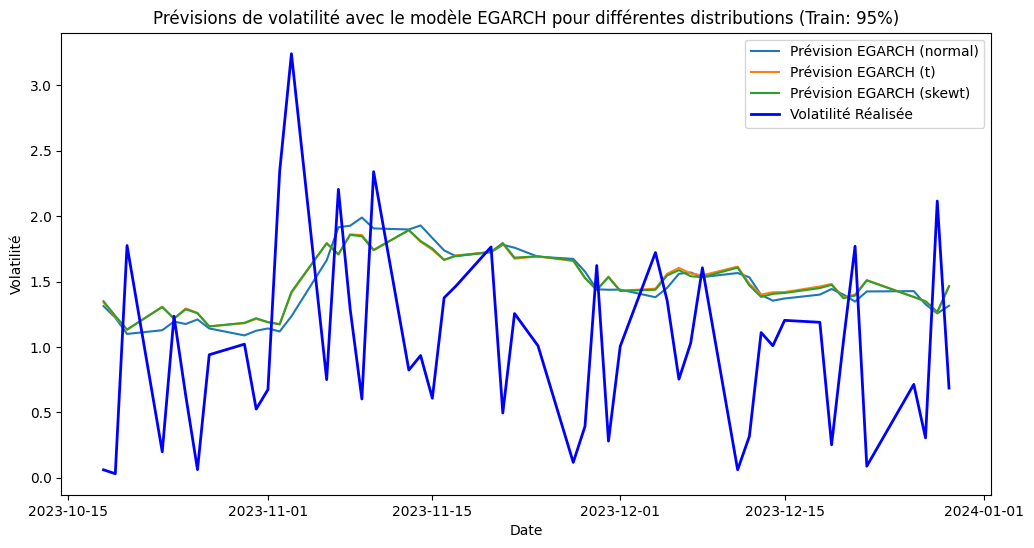

In [17]:
from arch import arch_model
import numpy as np
import matplotlib.pyplot as plt

all_rolling_predictions = []
train_size_ratio = 0.95

train_size = int(len(log_returns) * train_size_ratio)
train_data = log_returns[:train_size]
test_data = log_returns[train_size:]

scaling_factor = 100
scaled_train_data = train_data * scaling_factor
scaled_test_data = test_data * scaling_factor

distributions = ['normal', 't', 'skewt']
best_orders = []

for dist in distributions:
    best_aic = np.inf
    best_order = None

    for p in range(1, 3):
        for q in range(1, 3):
            try:
                # Implémentation du modèle EGARCH
                model = arch_model(scaled_train_data, vol='EGarch', p=p, q=q, dist=dist)
                model_fit = model.fit(disp='off')
                aic = model_fit.aic
                if aic < best_aic:
                    best_aic = aic
                    best_order = (p, q)
            except Exception as e:
                continue

    best_orders.append(best_order)
    rolling_predictions = []
    history = list(scaled_train_data)

    for t in range(len(scaled_test_data)):
        model = arch_model(history, vol='EGarch', p=best_order[0], q=best_order[1], dist=dist)
        model_fit = model.fit(disp='off')
        pred = model_fit.forecast(horizon=1)
        predicted_volatility = np.sqrt(pred.variance.values[-1, :][0])
        rolling_predictions.append(predicted_volatility)
        history.append(scaled_test_data[t])

    rolling_predictions = np.array(rolling_predictions)
    all_rolling_predictions.append(rolling_predictions)

realized_volatility = np.abs(test_data) * scaling_factor

plt.figure(figsize=(12, 6))

for idx, predictions in enumerate(all_rolling_predictions):
    plt.plot(test_data.index[:len(predictions)], predictions, label=f'Prévision EGARCH ({distributions[idx]})')

plt.plot(test_data.index, realized_volatility, label='Volatilité Réalisée', color='blue', linewidth=2)
plt.title('Prévisions de volatilité avec le modèle EGARCH pour différentes distributions (Train: 95%)')
plt.xlabel('Date')
plt.ylabel('Volatilité')
plt.legend()
plt.show()


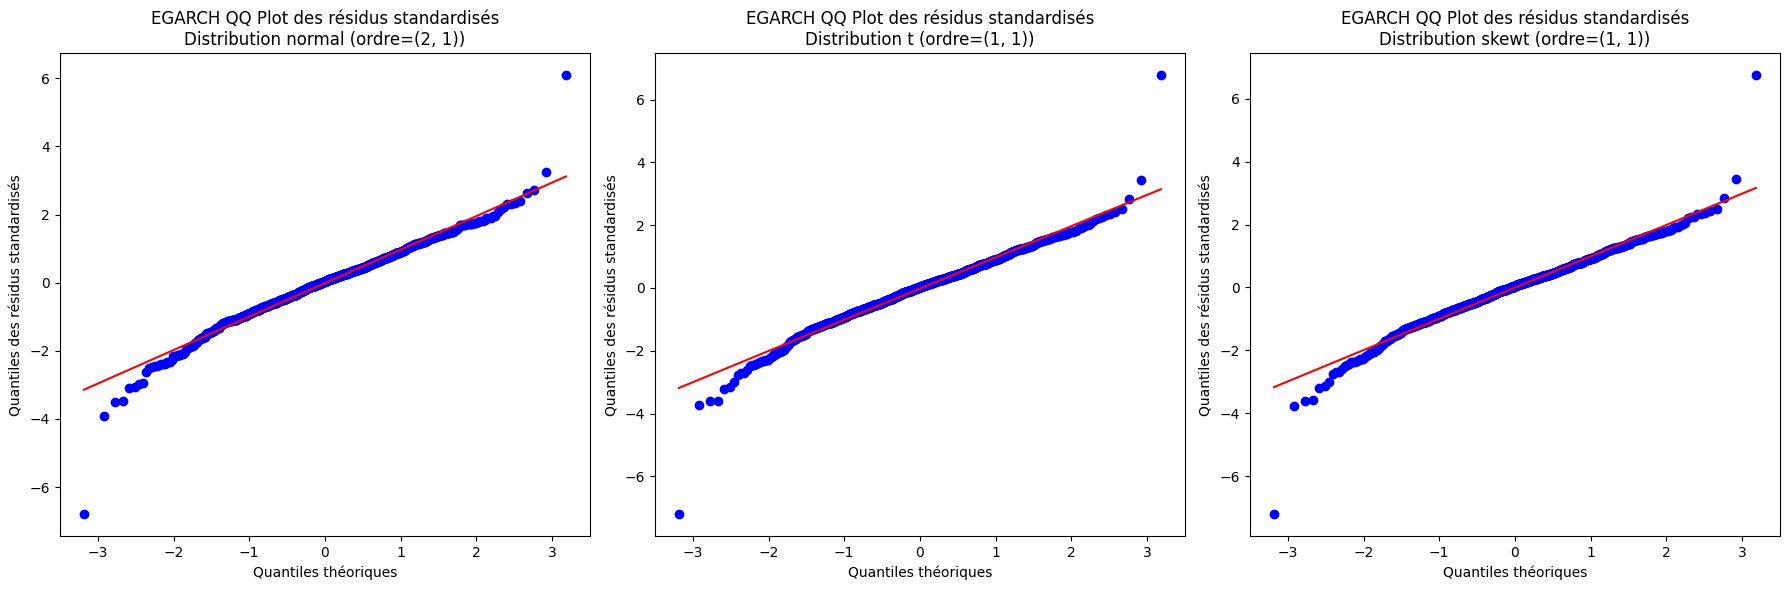

In [18]:


# Créer une figure pour afficher les QQ plots côte à côte
plt.figure(figsize=(18, 6))  # Largeur augmentée pour accueillir les plots côte à côte

# Boucle pour calculer et afficher le QQ plot pour chaque distribution
for idx, dist in enumerate(distributions):
    # Meilleur ordre trouvé pour la distribution actuelle
    best_order = best_orders[idx]

    # Ajustement du modèle EGARCH avec les meilleurs paramètres sur les données d'entraînement
    model = arch_model(scaled_train_data, vol='EGarch', p=best_order[0], q=best_order[1], dist=dist)
    model_fit = model.fit(disp='off')

    # Calcul des résidus standardisés
    standardized_residuals = model_fit.std_resid

    # Création du QQ plot dans une sous-figure
    plt.subplot(1, len(distributions), idx + 1)  # 1 ligne, nombre de colonnes = nombre de distributions
    stats.probplot(standardized_residuals, dist="norm", plot=plt)
    plt.title(f"EGARCH QQ Plot des résidus standardisés\nDistribution {dist} (ordre={best_order})")
    plt.xlabel("Quantiles théoriques")
    plt.ylabel("Quantiles des résidus standardisés")

# Ajustement de l'affichage et affichage final
plt.tight_layout()
plt.show()
